In [41]:
import import_ipynb
from fetch_data import get_stock_data

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib
import os
import sys
import datetime
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt

In [44]:
def train_xgboost_model(ticker: str):
    df = get_stock_data(ticker.lower())
    X = df.drop(['Date', 'Close'], axis=1)
    Y = df["Close"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, shuffle=False)
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.05,
        "max_depth": 6,
        "subsample": 1,
        "colsample_bytree": 0.8,
        "seed": 101
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
    y_pred = model.predict(dvalid)
    validation_dates = df['Date'].iloc[-len(y_valid):]
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    mape = np.mean(np.abs((y_valid - y_pred) / (y_valid + 1e-9))) * 100

    print(f"Model Performance for {ticker.upper()}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    plt.figure(figsize=(12, 6))
    plt.plot(validation_dates, y_valid.values, label='Actual Close Price', linewidth=2)
    plt.plot(validation_dates, y_pred, label='Predicted Close Price', linewidth=2)
    plt.title(f'{ticker.upper()} Model Analysis', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel("Predicted 'Close' Price of the Stock")
    plt.legend()
    plt.grid(True)
    plt.show()
    


[0]	train-rmse:25.21404	valid-rmse:125.36941
[50]	train-rmse:2.25492	valid-rmse:39.07137
[100]	train-rmse:0.58895	valid-rmse:33.45494
[150]	train-rmse:0.42219	valid-rmse:32.93551
[200]	train-rmse:0.36214	valid-rmse:32.97079
[206]	train-rmse:0.35566	valid-rmse:32.95374
Model Performance for NVDA:
RMSE: 32.9518
MAE:  24.7331
MAPE: 15.09%


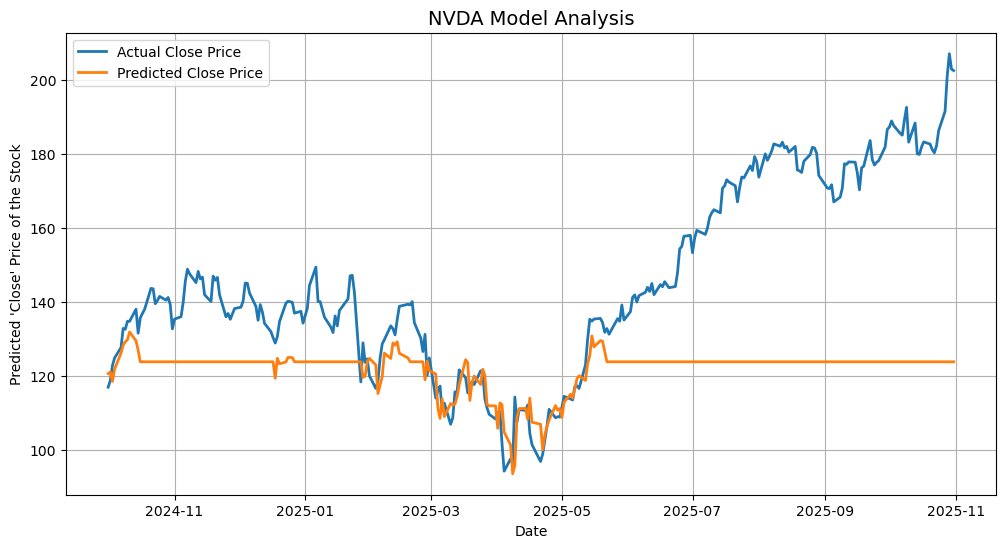

In [45]:
train_xgboost_model("NVDA")

[0]	train-rmse:59.10752	valid-rmse:131.07844
[50]	train-rmse:4.96807	valid-rmse:21.98501
[100]	train-rmse:1.40211	valid-rmse:15.34566
[150]	train-rmse:1.16470	valid-rmse:14.75207
[196]	train-rmse:1.04235	valid-rmse:14.80934
Model Performance for AAPL:
RMSE: 14.8146
MAE:  10.4434
MAPE: 4.39%


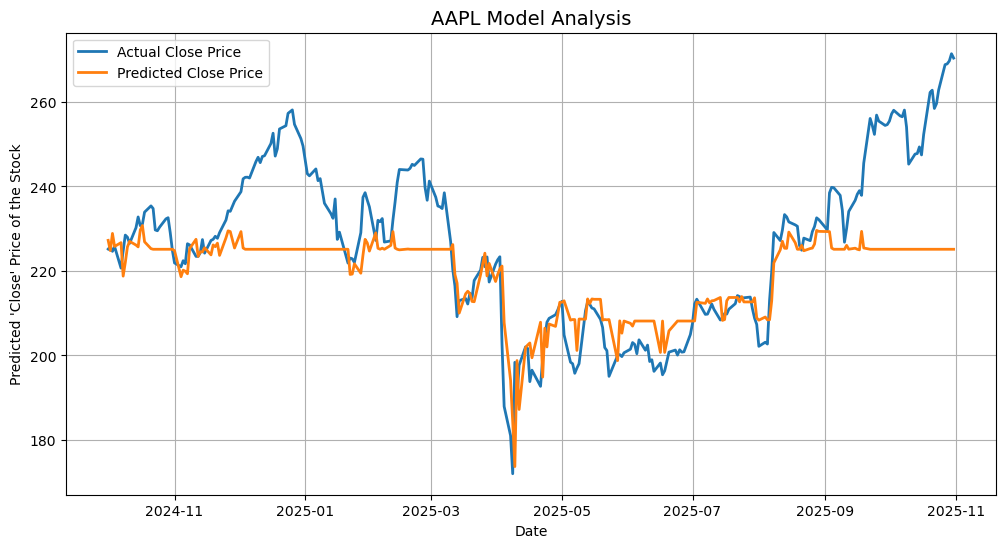

In [46]:
train_xgboost_model("AAPL")

In [32]:
from sklearn.preprocessing import StandardScaler

In [47]:
def train_random_forest(ticker: str):
    df = get_stock_data(ticker.lower())
    X = df.drop(['Date', 'Close'], axis=1)
    y = df['Close']
    split_idx = int(len(df) * 0.7)
    X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]
    dates_valid = df['Date'].iloc[split_idx:]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        oob_score=False
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    mape = np.mean(np.abs((y_valid - y_pred) / (y_valid + 1e-9))) * 100

    print(f"Model Performance for {ticker.upper()}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    plt.figure(figsize=(12, 6))
    plt.plot(dates_valid, y_valid.values, label='Actual Close Price', linewidth=2)
    plt.plot(dates_valid, y_pred, label='Predicted Close Price', linewidth=2)
    plt.title(f'{ticker.upper()} Random Forest Model Analysis', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel("Predicted 'Close' Price of the Stock")
    plt.legend()
    plt.grid(True)
    plt.show()


Model Performance for AAPL:
RMSE: 35.9830
MAE:  25.3016
MAPE: 11.43%


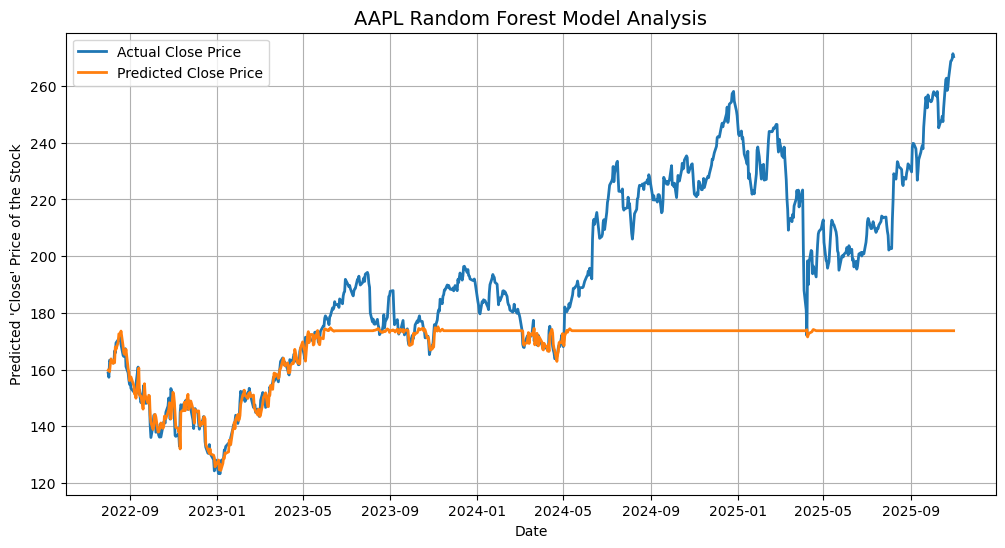

In [50]:
train_random_forest("AAPL")

In [73]:
def prophet_predict(ticker: str, periods: int = 30):
    df = get_stock_data(ticker.lower())
    df = df.sort_values('Date').reset_index(drop=True)
    df_prophet = df.rename(columns={'Date': 'ds', 'Close': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)
    split_idx = int(len(df_prophet) * 0.7)
    train = df_prophet.iloc[:split_idx]
    validation = df_prophet.iloc[split_idx:]
    lag_features = [col for col in df.columns if "lag" in col]
    model = Prophet(yearly_seasonality=True,weekly_seasonality=True,seasonality_mode="additive")
    for name in lag_features:
        model.add_regressor(name)
    model.fit(train)
    forecast_val = model.predict(validation[["ds"] + lag_features] if lag_features else validation[["ds"]])
    y_true = validation['y'].values
    y_pred = forecast_val['yhat'].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\nModel Performance for {ticker.upper()}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    future = model.make_future_dataframe(periods=periods)
    future['ds'] = pd.to_datetime(future['ds']).dt.tz_localize(None)
    for name in lag_features:
        future[name] = 0  
    forecast_future = model.predict(future)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(df["Date"].iloc[-365:], df["Close"].iloc[-365:], label="Actual", color="blue")

    plt.plot(forecast_val["ds"], forecast_val["yhat"], label="Validation Forecast", color="orange")
    plt.fill_between(
        forecast_val["ds"],
        forecast_val["yhat_lower"],
        forecast_val["yhat_upper"],
        color="orange",
        alpha=0.2,
        label="Validation Uncertainty"
    )

    plt.plot(
        forecast_future["ds"].iloc[-periods:],
        forecast_future["yhat"].iloc[-periods:],
        label=f"Future {periods}-Day Forecast"
    )
    plt.fill_between(
        forecast_future["ds"].iloc[-periods:],
        forecast_future["yhat_lower"].iloc[-periods:],
        forecast_future["yhat_upper"].iloc[-periods:],
        color="green",
        alpha=0.4,
        label="Future Uncertainty"
    )

    plt.xlabel("Date")
    plt.ylabel("Predicted `Close` price of Stock")
    plt.title(f"{ticker.upper()} Model Forecast ({periods} Days Ahead)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:25 - cmdstanpy - INFO - Chain [1] done processing



Model Performance for NVDA:
RMSE: 3.2487
MAE:  2.1114
MAPE: 2.55%


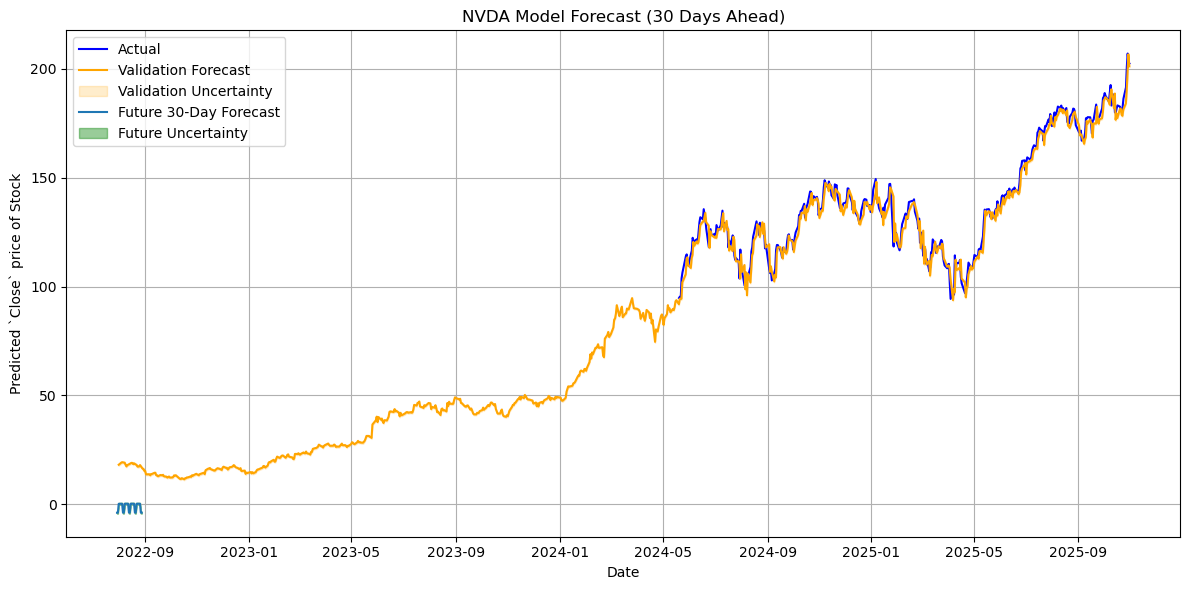

In [74]:
prophet_predict("NVDA")

23:18:26 - cmdstanpy - INFO - Chain [1] start processing
23:18:27 - cmdstanpy - INFO - Chain [1] done processing



Model Performance for AAPL:
RMSE: 3.4564
MAE:  2.3941
MAPE: 1.28%


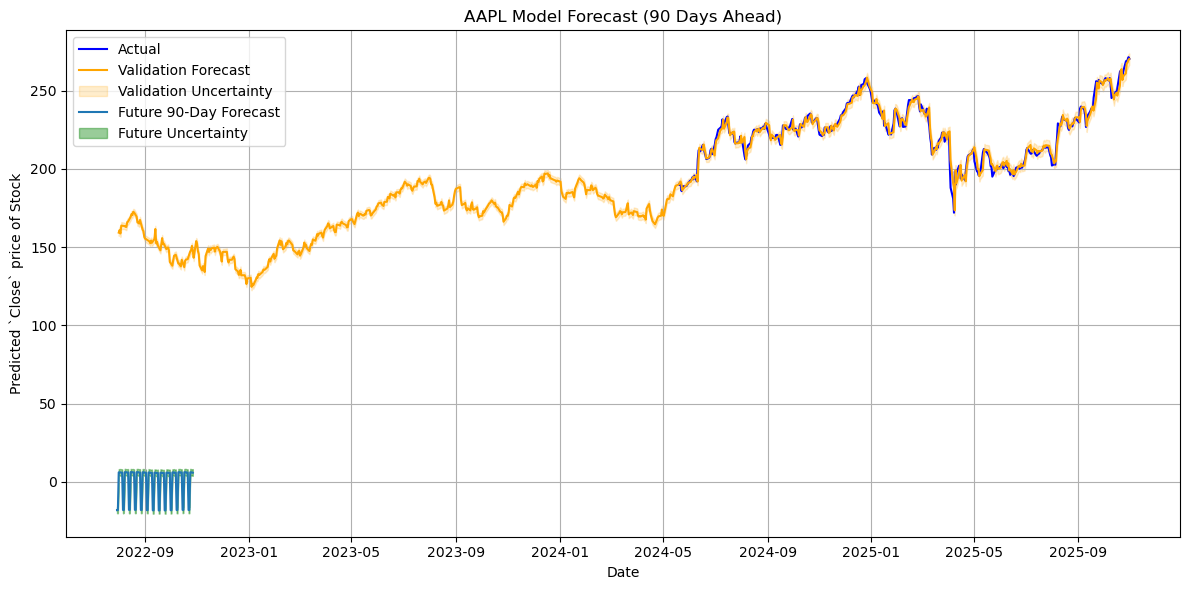

In [75]:
prophet_predict("AAPL",90)